In [1]:
import os, sys, re, functools, itertools, collections, time, random, pickle, warnings, json, subprocess
pkg_path = '/home/jupyter/code'
if pkg_path not in sys.path:
    sys.path.append(pkg_path)
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas

import torch
import torch.nn as nn

from utility import get_label_image, get_cor, get_cor_map, get_topk_indices, get_cor_map_4d, get_local_mean
from utility import get_prime_factors, get_local_median, scale_and_shift, adaptive_avg_pool
from visualization import imshow, plot_image_label_overlay, make_video_ffmpeg, get_good_colors, plot_colortable, save_gif_file
from models import UNet
from denoise import get_denoised_mat, model_denoise, SeparateNet
from segmentation import get_traces, semi_supervised_segmentation
from optical_electrophysiology import extract_traces

use_gpu = True
if use_gpu and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
%load_ext autoreload
%autoreload 2

In [2]:
def simple_cosine_similarity(x, y=None):
    """
    Args:
        x: (n_x, dim)
        y: (n_y, dim)
    
    Returns:
        cos: (n_x, n_y)
    """
    if y is None:
        y = x
    x = x - x.mean(1, keepdim=True)
    y = y - y.mean(1, keepdim=True)
    cos = torch.mm(x, y.T) / x.norm(dim=1, keepdim=True) / y.norm(dim=1)
    return cos

def manhattan_distance(coords):
    """
    Args:
        coords: (n_pts, ndim)
    """
    return (coords.unsqueeze(2) - coords.T).abs().sum(1)

def graph_laplacian(weight, normalized=True):
    """
    Args:
        weight: non-negative symmetric 2D matrix
       
    Returns:
        L: 
        
    """
    assert weight.ndim==2 and weight.min() >= 0
    diagonal = weight.sum(1)
    L = torch.diag(diagonal) - weight
    if normalized and diagonal.min() > 0:
        d = 1./torch.sqrt(diagonal)
        L = d.unsqueeze(0) * L * d.unsqueeze(1)
    return L

def pairwise_dist(x, y=None, sqrt=False):
    """
    Args:
        x: (n_pts, ndim)
        y: if None, set to be x
        
    """
    if y is None:
        y = x
    dist = (x*x).sum(1, keepdim=True) + (y*y).sum(1) - 2*torch.mm(x, y.T)
    dist[dist<0] = 0
    if sqrt:
        return torch.sqrt(dist)
    else:
        return dist

def k_means(points, n_clusters, random_init=False, return_centers=False):
    """
    Args:
        points: (n_pts, ndim)
    
    Returns:
        if return_centers is True:
            indices: (n_pts, ), LongTensor, labels
            values: (n_pts, ), distance to center
            centers: (n_clusters, ndim)
        
    Examples:
        good_colors = get_good_colors()
        points = torch.randn((100, 2))
        indices, values, centers = k_means(points, n_clusters=10, return_centers=True)
        fig, ax = plt.subplots(figsize=(20, 20))
        ax.scatter(points[:, 0].cpu().numpy(), points[:, 1].cpu().numpy(), c=[good_colors[i.item()] for i in indices], marker='o')
        ax.scatter(centers[:, 0].cpu(), centers[:, 1].cpu(), c=good_colors[:10], marker='v', s=50)
        plt.show()
    """
    n_pts, ndim = points.shape
    if random_init:
        centers = points[torch.randperm(n_pts)[:n_clusters]]
    else:
        sel_idx = np.random.choice(n_pts)
        centers = points[sel_idx].unsqueeze(0)
        for _ in range(n_clusters-1):
            dist = pairwise_dist(centers, points).min(dim=0)[0]
            sel_idx = torch.multinomial(dist, 1)
            centers = torch.cat([centers, points[sel_idx]], dim=0)
    labels = torch.zeros(n_pts).long().to(points.device)
    indices = torch.ones(n_pts).long().to(points.device)
    while not torch.equal(labels, indices):
        labels = indices
        dist = pairwise_dist(centers, points)
        values, indices = dist.min(dim=0) #ToDo: check empty clusters
        centers = torch.stack([points[indices==i].mean(0) for i in range(n_clusters)], dim=0)
    if return_centers:
        return indices, values, centers
    else:
        return indices, values.sum()

# Load data

In [3]:
data_folder = 'optosynth_test_mb'
# data_folder = '../data'

mat = torch.from_numpy(np.load(f'{data_folder}/mat.npy')).float().to(device)
trend = torch.from_numpy(np.load(f'{data_folder}/trend.npy')).float().to(device)
clean = torch.from_numpy(np.load(f'{data_folder}/clean.npy')).float().to(device)
masks = torch.from_numpy(np.load(f'{data_folder}/masks_nyx.npy')).to(device)
soma_coords = torch.from_numpy(np.load(f'{data_folder}/soma_coords_n2.npy')).to(device)
true_traces = torch.from_numpy(np.load(f'{data_folder}/neuron_mean_fluorescence_nt.npy')).float().to(device)
nframe, nrow, ncol = mat.shape
mask_soma = torch.zeros(nrow, ncol).bool()
mask_soma[soma_coords[:, 1], soma_coords[:, 0]] = True
mask_cell = masks.float().max(0)[0].bool()
target = clean - trend

del clean, trend
torch.cuda.empty_cache()

true_traces_median = get_local_median(true_traces, dim=-1)
true_traces -= true_traces_median

save_folder = '2d-noise2self_with_features'
filepath = f'{save_folder}/denoised_movie_full_step64000.npy'
denoised_mat = torch.from_numpy(np.load(filepath)).float().to(device)
median = get_local_median(denoised_mat, dim=0)
denoised_mat = denoised_mat - median
# mat_fft = torch.rfft(denoised_mat.transpose(0, 2), signal_ndim=1).reshape(ncol, nrow, -1).transpose(0, 2)

In [5]:
mat = torch.from_numpy(np.load('trefide_demo.npy')).to(device)

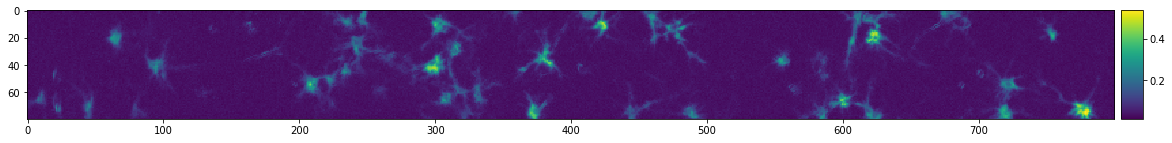

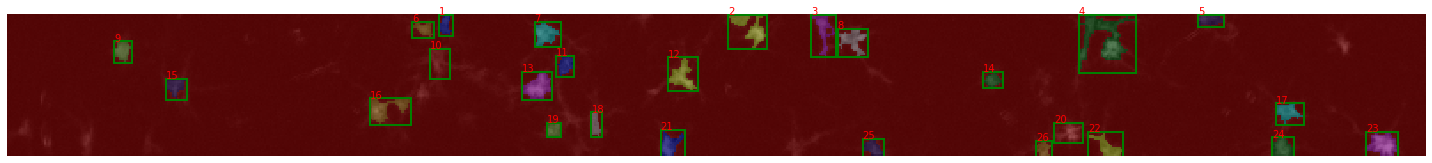

In [10]:
cor_map = get_cor_map(mat)
label_image, regions = get_label_image(cor_map)
label_image = torch.from_numpy(label_image).to(device)
imshow(cor_map)
plot_image_label_overlay(cor_map, label_image=label_image, regions=regions)

In [ ]:
def basic_segmentation(mat):
    cor_map = get_cor_map(mat)
    label_image, regions = get_label_image(cor_map)
    plot_image_label_overlay(cor_map, label_image=label_image, regions=regions)
cor_map = get_cor_map(mat)
label_image, regions = get_label_image(cor_map)
label_image = torch.from_numpy(label_image).to(device)
submats, traces = extract_traces(mat-median, softmask=cor_map, label_image=label_image, regions=regions)
submats_denoised, traces_denoised = extract_traces(denoised_mat, softmask=cor_map, label_image=label_image, regions=regions)

In [ ]:
regions = regionprops(label_image.cpu().numpy())
from utility import mark_points_in_intervals
box_coords = soma_coords.new_tensor(np.array([region.bbox for region in regions]))[:, [1, 3, 0, 2]]
box_coords = box_coords.reshape(box_coords.shape[0], box_coords.shape[1]//2, 2)
selected = mark_points_in_intervals(soma_coords, box_coords)
print('False Negatives (missed real neurons): {}'.format(torch.nonzero(selected.sum(1) == 0, as_tuple=True)[0].tolist()))
print('False Positives (empty boxes): {}'.format(torch.nonzero(selected.sum(0) == 0, as_tuple=True)[0].tolist()))
good_box_idx = torch.nonzero(selected.sum(0)==1, as_tuple=True)[0]
soma_idx = torch.nonzero(selected[:, good_box_idx].T, as_tuple=True)[1]
print('{} good boxes: {}'.format(len(good_box_idx), [(i+1, j+1) for i, j in zip(good_box_idx.tolist(), soma_idx.tolist())]))

# num_labels = label_image.max()
# fig, ax = plt.subplots(num_labels, figsize=(20, 10*num_labels))
# for i in range(len(traces)):
#     ax[i].plot(traces[i].cpu(), 'bo-', alpha=0.5, label=f'{i+1} raw')
#     ax[i].plot(traces_denoised[i].cpu(), 'ro-', alpha=0.5, label=f'{i+1} denoised')
#     ax[i].legend()
# fig.tight_layout()
# plt.show()

In [ ]:
from skimage.color import label2rgb
import matplotlib.patches as mpatches
from skimage.measure import regionprops

figsize = (20, 10)
sel_idx = None
image_label_overlay = label2rgb(label_image.cpu().numpy(), image=cor_map.cpu().numpy())
regions = regionprops(label_image.cpu().numpy())
fig, ax = plt.subplots(figsize=figsize)
ax.imshow(image_label_overlay)
for i, region in enumerate(regions):
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red' if sel_idx is not None and i==sel_idx else 'green', linewidth=2)
    ax.add_patch(rect)
    ax.text(minc, minr-1, i+1, color='g', fontweight='bold')
for i, (x, y) in enumerate(soma_coords):
    ax.scatter([x.item()], [y.item()], s=30, c='r')
    ax.text(x.item()+1, y.item(), i+1, color='r', fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [9]:
def split_clusters(sel_label_idx, mat, label_image, cor_threshold=0.8, min_num_pixels=50, max_num_pixels=1200, max_dist=2, verbose=True):
    coords = torch.stack(torch.nonzero(label_image==sel_label_idx, as_tuple=True), dim=1)
    if len(coords) <= min_num_pixels:
        return
    m = mat[:, coords[:, 0], coords[:, 1]]

    dist = manhattan_distance(coords)
    dist.fill_diagonal_(max_dist + 1)
    adj_mat = (dist <= max_dist)

    fft = torch.rfft(m.T, signal_ndim=1, normalized=True).reshape(m.size(1), -1)
    fft = fft - fft.mean(1, keepdim=True)
    norm = torch.norm(fft, dim=1)
    cor = torch.mm(fft, fft.T) / (norm.unsqueeze(1) * norm)
    cor[~adj_mat] = 0
    cor[cor < 0] = 0

    laplacian = graph_laplacian(cor)
    eigenvalues, eigenvectors = torch.symeig(laplacian, eigenvectors=True)

    k = 2
    labels, dist = k_means(eigenvectors[:,:k*3], k)
    bincount = torch.bincount(labels)
    val_cnt, idx_cnt = bincount.sort()
    if val_cnt[0] <= min_num_pixels and val_cnt[1] <= max_num_pixels:
        if verbose:
            print(bincount.tolist())
        return
    if val_cnt[0] <= min_num_pixels//2 and val_cnt[1] > max_num_pixels:
        row_idx, col_idx = coords[labels==idx_cnt[0]].T
        label_image[row_idx, col_idx] = 0
        if verbose:
            print(f'Reset {val_cnt[0]} pixels to background')
        return split_clusters(sel_label_idx, mat, label_image, cor_threshold=cor_threshold, min_num_pixels=min_num_pixels, max_dist=max_dist)
    x = torch.stack([m[:, labels==i].mean(1) for i in range(2)], dim=0)
    cor_val = simple_cosine_similarity(x[:1], x[1:]).item()
    if verbose:
        print(cor_val)
    if cor_val > cor_threshold:
        if verbose:
            print('cor_val > cor_threshold')
        return
    row_idx, col_idx = coords[labels==idx_cnt[0]].T
    label_image[row_idx, col_idx] = label_image.max() + 1
    if verbose:
        print(f'Split {sel_label_idx} into {sel_label_idx} ({val_cnt[1]}) and {label_image.max().item()} ({val_cnt[0]})')
    if (labels==idx_cnt[1]).sum() > min_num_pixels:
        return split_clusters(sel_label_idx, mat, label_image, cor_threshold=cor_threshold, min_num_pixels=min_num_pixels, max_dist=max_dist)

In [ ]:
sel_label_idx = 10
split_clusters(sel_label_idx, denoised_mat, label_image, cor_threshold=0.8, min_num_pixels=50, max_dist=2)

In [11]:
sel_label_idx = 1
while sel_label_idx <= label_image.max():
    print(sel_label_idx)
    split_clusters(sel_label_idx, mat, label_image, cor_threshold=0.8, min_num_pixels=50, max_dist=2)
    sel_label_idx += 1
bincount = torch.bincount(label_image.view(-1))

1
[35, 22]
2
0.596449077129364
Split 2 into 2 (121) and 27 (53)
[10, 111]
3
[14, 108]
4
0.15634094178676605
Split 4 into 4 (281) and 28 (95)
[269, 12]
5
[67, 12]
6
[36, 21]
7
[79, 42]
8
[93, 35]
9
[46, 32]
10
[48, 52]
11
[18, 52]
12
[103, 36]
13
0.9135187268257141
cor_val > cor_threshold
14
[12, 43]
15
[58, 26]
16
[144, 15]
17
[28, 69]
18
[32, 25]
19
[32, 30]
20
[28, 80]
21
[82, 27]
22
[36, 66]
23
[138, 31]
24
[32, 73]
25
[24, 46]
26
[36, 18]
27
[35, 18]
28
[92, 3]


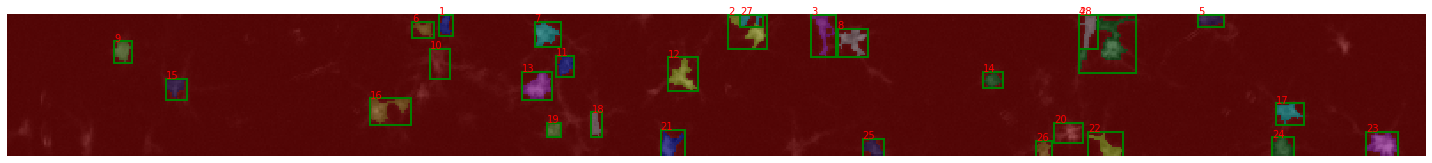

In [12]:
plot_image_label_overlay(cor_map, label_image=label_image)

In [ ]:
for sel_label_idx in range(1, label_image.max()+1):
    # minr, minc, maxr, maxc = regions[sel_label_idx-1].bbox
    # submat = mat[:, minr:maxr, minc:maxc]
    coords = torch.from_numpy(np.stack(np.nonzero(label_image == sel_label_idx), axis=1)).to(device)
    m = denoised_mat[:, coords[:, 0], coords[:, 1]]

    dist = manhattan_distance(coords)
    dist.fill_diagonal_(999)
    adj_mat = (dist <= 2)

    fft = torch.rfft(m.T, signal_ndim=1, normalized=True).reshape(m.size(1), -1)
    fft = fft - fft.mean(1, keepdim=True)
    norm = torch.norm(fft, dim=1)
    cor = torch.mm(fft, fft.T) / (norm.unsqueeze(1) * norm)
    cor[~adj_mat] = 0

    laplacian = graph_laplacian(cor)
    eigenvalues, eigenvectors = torch.symeig(laplacian, eigenvectors=True)
    # fig, ax = plt.subplots(figsize=(20, 20))
    # ax.set_title(sel_label_idx)
    # ax.plot(eigenvalues.tolist()[:50], 'o-')
    # ax.axvline(x=len(torch.nonzero(selected[:, sel_label_idx-1], as_tuple=True)[0]))
    # plt.show()

    k = 2
    labels, dist = k_means(eigenvectors[:,:k], k)
    image = torch.zeros_like(cor_map)
    image[coords[:, 0], coords[:, 1]] = image.new_tensor(labels+1)
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image.cpu().numpy())
    ax.set_title(f'{k} {dist.item()}')
    for i, (x, y) in enumerate(soma_coords):
        ax.scatter([x.item()], [y.item()], s=30, c='r')
        ax.text(x.item()+1, y.item(), i+1, color='r', fontweight='bold')
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

    neuron_idx = torch.nonzero(selected[:, sel_label_idx-1], as_tuple=True)[0]
    x = torch.stack([m[:, labels==i].mean(1) for i in range(2)], dim=0)
    y = true_traces[neuron_idx]
    print(simple_cosine_similarity(x[:1], x[1:]).item())
    print(simple_cosine_similarity(x, y).tolist())
    fig, ax = plt.subplots(2, figsize=(20, 20))
    for i in range(2):
        ax[0].plot(x[i].cpu(), label=i+1)
    for i, j in enumerate(neuron_idx):
        ax[1].plot(y[i].cpu(), label=j.item()+1)
    ax[0].legend()
    ax[1].legend()
    fig.tight_layout()
    plt.show()

In [ ]:
ks = range(1, 30, 3)
ds = []
for k in ks:
    labels, dist = k_means(eigenvectors[:,:k], k)
    image = torch.zeros_like(cor_map)
    image[coords[:, 0], coords[:, 1]] = image.new_tensor(labels+1)
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image.cpu().numpy())
    ax.set_title(f'{k} {dist.item()}')
    for i, (x, y) in enumerate(soma_coords):
        ax.scatter([x.item()], [y.item()], s=30, c='r')
        ax.text(x.item()+1, y.item(), i+1, color='r', fontweight='bold')
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()
    ds.append(dist.item())

plt.plot(ks, ds, 'o-')

In [ ]:
selected.sum(0)

In [ ]:
from utility import simple_linear_regression
for i, j in zip(good_box_idx, soma_idx):
    i = i.item()
    j = j.item()
    print(f'Box {i+1}, Soma {j+1}')
    print('cor(raw, denoised) = {:.2f}'.format(nn.functional.cosine_similarity(traces[i], traces_denoised[i], dim=0).item()))
    print('cor(raw, true) = {:.2f}'.format(nn.functional.cosine_similarity(traces[i], true_traces[j], dim=0)))
    print('cor(denoised, true) = {:.2f}'.format(nn.functional.cosine_similarity(traces_denoised[i], true_traces[j], dim=0)))
    fig, ax = plt.subplots(3)
    ax[0].plot(traces[i].cpu(), label='raw', alpha=0.5, c='b')
    ax[0].plot(traces_denoised[i].cpu(), label='denoised', c='r')
    ax[0].legend()
    ax[1].plot(true_traces[j].cpu(), c='g', label='true')
    ax[1].legend()
    ax[2].plot(simple_linear_regression(traces[i], true_traces[j], return_fitted=True).cpu(), label='raw', alpha=0.5, c='b')
    ax[2].plot(simple_linear_regression(traces_denoised[i], true_traces[j], return_fitted=True).cpu(), label='denoised', alpha=0.5, c='r')
    ax[2].plot(true_traces[j].cpu(), c='g', alpha=0.5, label='true')
    ax[2].legend()
    fig.tight_layout()
    plt.show()

In [ ]:
m = adaptive_avg_pool(mat, (256, nrow, ncol))

In [ ]:
m = torch.rfft(m.transpose(0, 2), signal_ndim=1, normalized=True)

In [ ]:
cor_map = get_cor_map(m.transpose(1, 2).transpose(0, 3).reshape(-1, 180, 512))

In [ ]:
imshow(cor_map)

In [ ]:
imshow(adaptive_avg_pool(m, label_image.shape))
imshow(label_image)

In [ ]:
sel_label = 8
idx1, idx2 = np.nonzero(label_image==sel_label)
order = cor_map[idx1, idx2].sort()[1].tolist()
idx1, idx2 = idx1[order], idx2[order]

In [ ]:
m = denoised_mat[:, idx1, idx2]

In [ ]:
f = torch.rfft((m - m.mean(0)).T, 1, normalized=True)

In [ ]:
f[:, 250:] = 0

In [ ]:
m2 = torch.irfft(f, 1, normalized=True, signal_sizes=[1000]).T

In [ ]:
plt.plot(m2[:, 0].cpu())
plt.show()
plt.plot(m[:, 0].cpu())

In [ ]:
plt.plot(f[0, :, 0].cpu())
plt.show()
plt.plot(f[0, :, 1].cpu())
plt.show()
plt.plot(m[:, 0].cpu())

In [ ]:
num_somas = selected.sum(0)
for i in range(1, label_image.max()+1):
    idx1, idx2 = np.nonzero(label_image==i)
    m = mat[:, idx1, idx2]
    with torch.no_grad():
        u, s, v = torch.svd(m)
    plt.plot(s[1:].cpu(), 'o-')
    plt.title('{}: {}: {}'.format(i+1, num_somas[i-1].item(), s[:5].tolist()))
    plt.show()

In [ ]:
num_somas = selected.sum(0)
for i, submat in enumerate(submats):
    m = adaptive_avg_pool(submat, (256, 16, 16)).reshape(256, 256)
    with torch.no_grad():
        eigenvalues, eigenvectors = torch.eig(m)
        eigenvalues = torch.norm(eigenvalues, dim=1)
    plt.plot(eigenvalues.cpu()[1:], 'o-')
    plt.title('{}: {}: {}'.format(i+1, num_somas[i].item(), eigenvalues[:5].tolist()))
    plt.show()

In [ ]:
i = 0
submats[i].shape

In [ ]:
box_coords[0]

In [ ]:
cor_maps = [get_cor_map(m) for m in [mat, denoised_mat, target]]

In [ ]:
m = target
noisy = m + torch.randn_like(m) * m.std()*0.1
cor = get_cor_map(noisy)

In [ ]:
imshow(masks.sum(0))

In [ ]:
fig_folder = f'{data_folder}/individual_neurons'
if not os.path.exists(fig_folder):
    print(f'Create {fig_folder}')
    os.makedirs(fig_folder)
if not os.path.exists(f'{fig_folder}/individual_neurons.gif'):
    for i in range(len(masks)):
        y, x = torch.nonzero(masks[i], as_tuple=True)
        fig, ax = plt.subplots(figsize=(16, 9))
        im = ax.imshow(cor_map.cpu().numpy(), cmap='gray')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.1)
        fig.colorbar(im, cax=cax)
        ax.scatter(x.cpu().numpy(), y.cpu().numpy(), c='g', s=3, alpha=0.5)
        ax.scatter(soma_coords[i, 0].cpu().numpy(), soma_coords[i, 1].cpu().numpy(), c='r', alpha=0.5)
        ax.set_title(f'Neuron {i} (soma is red)')
        fig.tight_layout()
        plt.savefig(f'{fig_folder}/{i}.png')
        plt.close()
    save_gif_file(imgs=[f'{fig_folder}/{i}.png' for i in range(len(masks))], save_path=f'{fig_folder}/individual_neurons.gif')

    img = masks.sum(0).cpu()
    fig, ax = plt.subplots(figsize=(16, 9))
    im = ax.imshow(img, cmap=matplotlib.cm.get_cmap('viridis', img.max()+1))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.1)
    fig.colorbar(im, cax=cax)
    ax.scatter(soma_coords[:, 0].cpu().numpy(), soma_coords[:, 1].cpu().numpy(), c='r', s=20, alpha=0.5)
    ax.set_title('Overlapping of neurons (red dots are somas)')
    fig.tight_layout()
    plt.savefig(f'{fig_folder}/overlapping.png')
    plt.show()
    
if not os.path.exists(f'{fig_folder}/individual_neurons_with_spikes.gif'):
    for i in range(len(masks)):
        y, x = torch.nonzero(masks[i], as_tuple=True)
        fig, ax = plt.subplots(2, figsize=(16, 16))
        im = ax[0].imshow(cor_map.cpu().numpy(), cmap='gray')
        divider = make_axes_locatable(ax[0])
        cax = divider.append_axes("right", size="2%", pad=0.1)
        fig.colorbar(im, cax=cax)
        ax[0].scatter(x.cpu().numpy(), y.cpu().numpy(), c='g', s=3, alpha=0.5)
        ax[0].scatter(soma_coords[i, 0].cpu().numpy(), soma_coords[i, 1].cpu().numpy(), c='r', alpha=0.5)
        ax[0].set_title(f'Neuron {i} (soma is red)')
        ax[1].plot(traces[i].cpu())
        ax[1].set_title(f'Neuron {i} mean fluorescence trace')
        fig.tight_layout()
        plt.savefig(f'{fig_folder}/{i}.png')
        plt.close()
    save_gif_file(imgs=[f'{fig_folder}/{i}.png' for i in range(len(masks))], save_path=f'{fig_folder}/individual_neurons_with_spikes.gif')

# Spectral clustering

In [ ]:
cor_map = get_cor_map(mat, topk=5)
label_image, regions = get_label_image(cor_map, plot=False)

In [ ]:
torch.save(model, 'model.pt')

In [ ]:
model = torch.load('model.pt')

In [ ]:
torch.cuda.empty_cache()
start_time = time.time()
soft_mask, model = semi_supervised_segmentation(mat, cor_map=cor_map, model=None, out_channels=[8,8,8,8], 
                                                kernel_size=3, frames_per_iter=100, num_iters=100, 
                                                print_every=20, select_frames=False, optimizer_fn=torch.optim.AdamW, 
                                                optimizer_fn_args = {'lr': 1e-2, 'weight_decay': 1e-3}, 
                                                save_loss_folder=None, loss_threshold=0, reduction='mean',
                                                last_out_channels=None,
                                                return_model=True, verbose=True)
print(time.time() - start_time)

In [ ]:
imshow(cor_map)
imshow(soft_mask)

In [ ]:
torch.cuda.empty_cache()
frames_per_iter = 100
num_iters = 10
start_time = time.time()
with torch.no_grad():
    soft_masks = []
    starts = []
    for i in range(num_iters):
        start = np.random.choice(901)
        starts.append(start)
        x = mat[start:start+frames_per_iter]
        y_pred = model(x).mean(1)
        soft_mask = torch.softmax(y_pred, dim=0)[1]
        soft_masks.append(soft_mask)
end_time = time.time()
print(f'Time spent: {end_time - start_time}')
soft_mask = torch.stack(soft_masks, dim=0).mean(0)

In [ ]:
for i, s in enumerate(starts):
    fig, ax = plt.subplots(2)
    ax[0].plot(mat[s:s+frames_per_iter].mean((1,2)).cpu())
    ax[0].set_title(f'{s}-{s+frames_per_iter}')
    im = ax[1].imshow(soft_masks[i].cpu().numpy())
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes("right", size="2%", pad=0.1)
    fig.colorbar(im, cax=cax)
    fig.tight_layout()
    plt.show()

In [ ]:
plt.imshow(soft_mask.cpu(), cmap='Reds', alpha=0.5)
plt.imshow(cor_map.cpu(), cmap='Blues', alpha=0.5)

In [ ]:
soft_mask = torch.stack(soft_masks, dim=0).mean(0)
imshow(soft_mask)

In [ ]:
for i in range(len(masks)):
    fig, ax = plt.subplots(figsize=(16, 9))
    im = ax.imshow(soft_mask.cpu().numpy(), cmap='gray', alpha=1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.1)
    fig.colorbar(im, cax=cax)
    y, x = torch.nonzero(masks[i], as_tuple=True)
    ax.scatter(x.cpu().numpy(), y.cpu().numpy(), c='g', s=3, alpha=0.2)
    ax.scatter(soma_coords[i, 0].cpu().numpy(), soma_coords[i, 1].cpu().numpy(), c='r', alpha=0.5)
    ax.set_title(f'Neuron {i} (soma is red)')
    fig.tight_layout()
    plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
im = ax.imshow(soft_mask.cpu().numpy(), cmap='gray', alpha=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
fig.colorbar(im, cax=cax)
for i in range(len(masks)):
    y, x = torch.nonzero(masks[i], as_tuple=True)
    ax.scatter(x.cpu().numpy(), y.cpu().numpy(), c='g', s=3, alpha=0.2)
for i in range(len(masks)):
    ax.scatter(soma_coords[i, 0].cpu().numpy(), soma_coords[i, 1].cpu().numpy(), c='r', alpha=0.5)
ax.set_title(f'Neuron masks (soma is red)')
fig.tight_layout()
plt.show()

In [ ]:
from skimage.color import label2rgb
import matplotlib.patches as mpatches
bounding_box = True
img = label2rgb(label_image, image=cor_map.cpu())
fig, ax = plt.subplots(figsize=(16, 9))
im = ax.imshow(img)
if bounding_box:
    for i, region in enumerate(regions):
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='green', linewidth=2)
        ax.add_patch(rect)
        ax.text(minc, minr, i+1, color='r')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
fig.colorbar(im, cax=cax)
ax.scatter(soma_coords[:, 0].cpu().numpy(), soma_coords[:, 1].cpu().numpy(), c='r', s=20, alpha=0.5)
for i, (x, y) in enumerate(soma_coords):
    ax.text(x, y, i, color='b')
ax.set_title('Basic pipeline segmentation')
ax.set_axis_off()
fig.tight_layout()
# if not os.path.exists(f'{fig_folder}/segmentation_basic.png'):
#     plt.savefig(f'{fig_folder}/segmentation_basic.png')
plt.show()

In [ ]:
label_idx = 1
num_components = 4
minr, minc, maxr, maxc = regions[label_idx-1].bbox
selected_frame_slice = slice(100, 700)
selected_row_slice = slice(minr, maxr)
selected_col_slice = slice(minc, maxc)
selected_indices = (selected_frame_slice, selected_row_slice, selected_col_slice)

submat = denoised_mat[selected_indices]
mask = None
# sub_cor_map = get_cor_map(submat)
# sub_label_image, sub_regions = get_label_image(sub_cor_map, plot=True)


# submat = denoised_mat[selected_frame_slice, label_image==label_idx]
# mask = (label_image == label_idx)[selected_row_slice, selected_col_slice]

W, H = plain_nmf(submat, n=num_components, mask=mask, fig_folder=None, save_npy=False)

In [ ]:
neuron_idx = 31
# plt.plot(target[selected_frame_slice, soma_coords[neuron_idx, 1], soma_coords[neuron_idx, 0]].cpu())
plt.plot(traces[neuron_idx, selected_frame_slice].cpu())
plt.show()

# Plain NMF

In [ ]:
save_folder = '2d-noise2self_with_features'
filepath = f'{save_folder}/denoised_movie_full_step64000.npy'
pred = torch.from_numpy(np.load(filepath)).float().to(device)
select_idx = range(100, 700)

In [ ]:
spike_name = 'median-5'
pred_filtered = get_local_median(pred, window_size=15, dim=0)

In [ ]:
filepath = f'{save_folder}/mb-spike/spike.npy'
spike_name = 'mb-spike'
pred_filtered = torch.from_numpy(np.load(filepath)).float().to(device)

In [ ]:
make_video_ffmpeg(torch.cat([scale_and_shift(m, scale=255) 
                             for m in [target[select_idx], pred[select_idx], pred_filtered[[select_idx]]]], dim=1), 
                  f'{spike_name}.avi', 
                  normalize=False)

In [ ]:
M = pred_filtered[select_idx].reshape(600, -1).cpu().numpy()
min_val = M.min()
M = M - min_val

In [ ]:
from sklearn.decomposition import NMF
ns = [51]
fig_folder = f'{save_folder}/nmf_spike/{spike_name}'
if not os.path.exists(fig_folder):
    print(f'Creat folder {fig_folder}')
    os.makedirs(fig_folder)
for n in ns:
    start_time = time.time()
    model = NMF(n_components=n, init='random', random_state=0)
    W = model.fit_transform(M)
    H = model.components_
    end_time = time.time()
    print(n, end_time - start_time)
    np.save(f'{fig_folder}/w_{n}.npy', W)
    np.save(f'{fig_folder}/h_{n}.npy', H)

In [ ]:
for i in range(H.shape[0]):
    fig, ax = plt.subplots(2, figsize=(20, 15))
    ax[0].set_title(f'Component {i+1}')
    im = ax[0].imshow(H[i].reshape(180, 512))
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes("right", size="2%", pad=0.1)
    fig.colorbar(im, cax=cax)
    ax[1].plot(W[:, i])
    fig.tight_layout()
    plt.savefig(f'{fig_folder}/{i}.png')
    plt.close()
#     plt.show()

In [ ]:
from PIL import Image, ImageSequence
# Create the frames
frames = []
imgs = [f'{fig_folder}/{n}.png' for n in range(H.shape[0])]
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
frames[0].save(f'{fig_folder}/nmf.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=1500, loop=0)

In [ ]:
cor_map = get_cor_map(mat, topk=4)
target = clean - trend

fig, ax = plt.subplots(3, figsize=(16, 21))
im = ax[0].imshow(cor_map.cpu().numpy())
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="2%", pad=0.1)
fig.colorbar(im, cax=cax)
ax[0].scatter(soma_coords[:, 0].cpu().numpy(), soma_coords[:, 1].cpu().numpy(), c='r')
ax[0].set_title('correlation map of noisy video (red dots are somas)')
im = ax[1].imshow(target.mean(0).cpu().numpy())
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="2%", pad=0.1)
fig.colorbar(im, cax=cax)
ax[1].scatter(soma_coords[:, 0].cpu().numpy(), soma_coords[:, 1].cpu().numpy(), c='r')
ax[1].set_title('temporal mean of the clean video (red dots are somas)')
im = ax[2].imshow(clean.mean(0).cpu().numpy())
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="2%", pad=0.1)
fig.colorbar(im, cax=cax)
ax[2].scatter(soma_coords[:, 0].cpu().numpy(), soma_coords[:, 1].cpu().numpy(), c='r')
ax[2].set_title('temporal mean of the clean video (before detrending)')
fig.tight_layout()
plt.savefig(f'{data_folder}/cor_map.png')
plt.show()

fig, ax = plt.subplots(10, 5, figsize=(20, 30))
for i in range(50):
    x, y = i//5, i%5
    ax[x, y].imshow((cor_map*masks[i].float()).cpu().numpy())
    ax[x, y].set_title(f'{i}')
    ax[x, y].scatter(soma_coords[i, 0].cpu().numpy(), soma_coords[i, 1].cpu().numpy(), c='r')
fig.tight_layout()
plt.title('Individual neurons on correlation map')
plt.savefig(f'{data_folder}/individual_neurons_cor_map.png')
plt.show()

plt.figure(figsize=(10, 30))
plt.plot(traces.T.cpu())
plt.title('Neuron mean fluorescence')
plt.savefig(f'{data_folder}/individual_neurons_mean_fluorescence.png')
plt.show()

In [ ]:
raw_traces = torch.stack([mat[:, mask].mean(dim=1) for mask in masks], dim=1).T.cpu().numpy()
clean_traces = torch.stack([target[:, mask].mean(dim=1) for mask in masks], dim=1).T.cpu().numpy()
step = np.max(clean_traces.max(1) - clean_traces.min(1))
fig, ax = plt.subplots(figsize=(10, 80))
for i in range(len(raw_traces)):
    ax.plot(raw_traces[i] - i*step, 'g-.', markersize=1, alpha=0.8, label='noisy' if i==0 else None)
    ax.plot(clean_traces[i] - i*step, 'r-', markersize=1, alpha=0.5, label='clean' if i==0 else None)
    ax.text(-30, -i*step, f'{i+1}')
ax.set_ylim(-step*len(raw_traces), step)
ax.legend()
ax.set_title('Mean traces (noisy and clean)')
plt.savefig(f'{data_folder}/mean_traces.png')
plt.show()

raw_traces = mat[:, mask_soma].T.cpu().numpy()
clean_traces = target[:, mask_soma].T.cpu().numpy()
step = np.max(clean_traces.max(1) - clean_traces.min(1))
fig, ax = plt.subplots(figsize=(10, 80))
for i in range(len(raw_traces)):
    ax.plot(raw_traces[i] - i*step, 'g-.', markersize=1, alpha=0.8, label='noisy' if i==0 else None)
    ax.plot(clean_traces[i] - i*step, 'r-', markersize=1, alpha=0.5, label='clean' if i==0 else None)
    ax.text(-30, -i*step, f'{i+1}')
ax.set_ylim(-step*len(raw_traces), step)
ax.legend()
ax.set_title('Soma traces (noisy and clean)')
plt.savefig(f'{data_folder}/soma_traces.png')
plt.show()

In [ ]:
command = ['gsutil', 'cp', f'{data_folder}/*png', f'gs://tma-opp-test/optosynth/optosynth_test_mb/data/']
response = subprocess.run(command)
assert response.returncode == 0

In [ ]:
save_folder = 'cellmincer-with_global_features_mse'
if not os.path.exists(save_folder):
    print(f'Download folder gs://tma-opp-test/optosynth/optosynth_test_mb/results/{save_folder}')
    command = ['gsutil', '-m', 'cp', '-r', f'gs://tma-opp-test/optosynth/optosynth_test_mb/results/{save_folder}', '.']
    response = subprocess.run(command, capture_output=True)
    assert response.returncode == 0

# Noise2Self

In [ ]:
print(save_folder)
movie_start_idx = 100
movie_end_idx = 700
if re.search('cellmincer', save_folder):
    num_epochs = 80
    if re.search('epochs', save_folder):
        num_epochs = int(save_folder[-8:-6])
    num_iters = 1000
else:
    with open(f'{save_folder}/config.json', 'r') as f:
        config = json.load(f)
    num_episodes = len([k for k in config.keys() if re.search('^episode', k)])
    num_epochs = sum([config[f'episode{e}']['train_settings']['num_epochs'] for e in range(num_episodes)])
    num_iters = config['episode0']['train_settings']['num_iters']
print(num_iters, num_epochs)

In [ ]:
target = (clean-trend)[movie_start_idx:movie_end_idx]
if not os.path.exists(f'{data_folder}/movie_frame{movie_start_idx}to{movie_end_idx}_clean.avi'):
    print(f'Make video {data_folder}/movie_frame{movie_start_idx}to{movie_end_idx}_clean.avi')
    make_video_ffmpeg(target, save_path=f'{data_folder}/movie_frame{movie_start_idx}to{movie_end_idx}_clean.avi')
losses = []
losses_train = []
for epoch in range(num_epochs):
    pred = target.new_tensor(
        np.load(f'{save_folder}/denoised_movie_frame{movie_start_idx}to{movie_end_idx}_step{num_iters * (epoch+1)}.npy', allow_pickle=True))
    losses.append([get_loss(pred, target, mask=None),
                   get_loss(pred, target, mask=mask_cell),
                   get_loss(pred, target, mask=mask_soma),
                   get_loss(pred, target, mask=~mask_cell)])
    losses_train.append([get_loss(pred, mat[movie_start_idx:movie_end_idx], mask=None),
                   get_loss(pred, mat[movie_start_idx:movie_end_idx], mask=mask_cell),
                   get_loss(pred, mat[movie_start_idx:movie_end_idx], mask=mask_soma),
                   get_loss(pred, mat[movie_start_idx:movie_end_idx], mask=~mask_cell)])
    print(epoch, losses[-1])
    print(epoch, losses_train[-1])
save_path = f'{save_folder}/diff_movie_frame{movie_start_idx}to{movie_end_idx}_step{num_iters * (epoch+1)}.avi'
make_video_ffmpeg(pred - target, 
                  save_path=save_path)
command = ['gsutil', 'cp', save_path, f'gs://tma-opp-test/optosynth/optosynth_test_mb/results/{save_folder}/']
response = subprocess.run(command)
assert response.returncode == 0
losses = np.array(losses)
pandas.DataFrame(losses, columns=['all', 'cell', 'soma', 'background']).to_pickle(f'{save_folder}/rmse_losses.pkl')
losses_train = np.array(losses_train)
pandas.DataFrame(losses_train, columns=['all', 'cell', 'soma', 'background']).to_pickle(f'{save_folder}/rmse_losses_train.pkl')
fig, ax = plt.subplots(5, sharex=True, figsize=(10, 20))
ax[0].plot(losses[:, 0], 'ro-', label='all')
ax[0].legend()
ax[1].plot(losses[:, 1], 'bo-', label='cell')
ax[1].legend()
ax[2].plot(losses[:, 2], 'go-', label='soma')
ax[2].legend()
ax[3].plot(losses[:, 3], 'ko-', label='background')
ax[3].legend()
ax[4].plot(losses[:, 0], 'ro-', label='all')
ax[4].plot(losses[:, 1], 'bo-', label='cell')
ax[4].plot(losses[:, 2], 'go-', label='soma')
ax[4].plot(losses[:, 3], 'ko-', label='background')
ax[4].legend()
fig.tight_layout()
plt.savefig(f'{save_folder}/rmse_losses.png')
plt.show()

fig, ax = plt.subplots(5, sharex=True, figsize=(10, 20))
ax[0].plot(losses_train[:, 0], 'ro-', label='all')
ax[0].legend()
ax[1].plot(losses_train[:, 1], 'bo-', label='cell')
ax[1].legend()
ax[2].plot(losses_train[:, 2], 'go-', label='soma')
ax[2].legend()
ax[3].plot(losses_train[:, 3], 'ko-', label='background')
ax[3].legend()
ax[4].plot(losses_train[:, 0], 'ro-', label='all')
ax[4].plot(losses_train[:, 1], 'bo-', label='cell')
ax[4].plot(losses_train[:, 2], 'go-', label='soma')
ax[4].plot(losses_train[:, 3], 'ko-', label='background')
ax[4].legend()
fig.tight_layout()
plt.savefig(f'{save_folder}/rmse_losses_train.png')
plt.show()

command = ['gsutil', 'cp', f'{save_folder}/rmse*', f'gs://tma-opp-test/optosynth/optosynth_test_mb/results/{save_folder}/']
response = subprocess.run(command)
assert response.returncode == 0

In [ ]:
# i = 3200
# model.load_state_dict(torch.load(f'{save_folder}/model_step{i}.pt'))

# mean_mat = mat.mean()
# std_mat = mat.std()
# denoised_mat = model_denoise(((mat - mean_mat) / std_mat)[movie_start_idx-frame_depth:movie_end_idx+frame_depth], model, ndim=ndim, frame_depth=frame_depth,
#                                  normalize=False, batch_size=batch_size_eval, replicate_pad=False)
# denoised_mat = denoised_mat * std_mat + mean_mat

# np.save(f'{save_folder}/denoised_movie_frame100to700_step{i}.npy', denoised_mat.cpu().numpy())

In [ ]:
save_folder = '2d-noise2self_with_features'
num_iters = 1600
num_epochs = 40
# save_folder = 'cellmincer-with_global_features'
# num_iters = 1000
# num_epochs = 80

filepath = f'{save_folder}/denoised_movie_frame100to700_step{num_iters*num_epochs}.npy'
if not os.path.exists(filepath):
    command = ['gsutil', '-m', 'cp', f'gs://tma-opp-test/optosynth/optosynth_test_mb/results/{filepath}', filepath]
    response = subprocess.run(command, capture_output=True)
    assert response.returncode == 0
pred = target.new_tensor(np.load(filepath))
# cor_map = get_cor_map(pred)
# imshow(cor_map, title='correlation map of predicted video', save_file=f'{save_folder}/cor_map_pred_{num_epochs}epochs.png')

In [ ]:
target = clean - trend
if re.search('cellmincer', save_folder):
    pred = target.new_tensor(np.load(f'{save_folder}/denoised_movie_frame0to1000_step{num_iters*num_epochs}.npy'))
else:
    pred = target.new_tensor(np.load(f'{save_folder}/denoised_movie_full_step{num_iters*num_epochs}.npy'))
cor_map = get_cor_map(pred-target, topk=4)
fig, ax = plt.subplots(3, figsize=(20, 20))
im = ax[0].imshow((pred-target).mean(0).cpu())
ax[0].set_title('temporal mean of (pred - target)')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="2%", pad=0.1)
fig.colorbar(im, cax=cax)
im = ax[1].imshow((pred-target).abs().mean(0).cpu())
ax[1].set_title('temporal mean of |pred - target|')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="2%", pad=0.1)
fig.colorbar(im, cax=cax)
im = ax[2].imshow(cor_map.cpu())
ax[2].set_title('correlation map of (pred - target)')
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="2%", pad=0.1)
fig.colorbar(im, cax=cax)
fig.tight_layout()
plt.savefig(f'{save_folder}/temporal_mean_difference_{num_epochs}epochs.png')
plt.show()

fig, ax = plt.subplots(3, figsize=(16, 16))
ax[0].set_title('spatial mean')
ax[0].plot(pred.mean((1, 2)).cpu(), label='pred')
ax[0].plot(target.mean((1,2)).cpu(), label='target')
ax[0].legend()
ax[1].plot((pred-target).abs().mean((1,2)).cpu(), label='|pred - target|')
ax[1].legend()
ax[2].plot((pred-target).mean((1,2)).cpu(), label='pred - target')
ax[2].legend()
plt.savefig(f'{save_folder}/spatial_mean_difference_{num_epochs}epochs.png')
plt.show()

raw_traces = mat[:, mask_soma].T.cpu().numpy()
pred_traces = pred[:, mask_soma].T.cpu().numpy()
clean_traces = target[:, mask_soma].T.cpu().numpy()
step = np.max(clean_traces.max(1) - clean_traces.min(1))
fig, ax = plt.subplots(figsize=(10, 80))
for i in range(len(raw_traces)):
    ax.plot(raw_traces[i] - i*step, 'b-', markersize=1, alpha=0.3, label='Input' if i==0 else None)
    ax.plot(pred_traces[i] - i*step, 'g-', markersize=1, alpha=0.8, label='Prediction' if i==0 else None)
    ax.plot(clean_traces[i] - i*step, 'r-', markersize=1, alpha=0.5, label='Target'if i==0 else None)
    ax.text(-30, -i*step, f'{i+1}')
ax.set_ylim(-step*len(clean_traces), step)
ax.legend()
ax.set_title('Predicted soma traces')
plt.savefig(f'{save_folder}/denoised_soma_traces_{num_epochs}epochs.png')
plt.show()

In [ ]:
command = ['gsutil', 'cp', f'{save_folder}/*.png', f'gs://tma-opp-test/optosynth/optosynth_test_mb/results/{save_folder}/']
response = subprocess.run(command)
assert response.returncode == 0

In [ ]:
command = ['gsutil', 'ls', 'gs://tma-opp-test/optosynth/optosynth_test_mb/results/']
response = subprocess.run(command, capture_output=True)
assert response.returncode == 0
folders = [f.split('/')[-2] for f in response.stdout.decode().split() if re.search('/$', f) and not re.search('figures|diff_movies', f)]
movie_start_idx = 100
movie_end_idx = 700

In [ ]:
folders = ['2d-noise2self_with_features', '2d-noise2self_with_features_80epochs', '2d-noise2self_with_features_80epochs_2',
           'cellmincer-with_global_features', 'cellmincer-with_global_features_mse']

In [ ]:
for folder in folders:
    if not os.path.exists(folder):
        print(folder)
        os.makedirs(folder)
        command = ['gsutil', 'cp', f'gs://tma-opp-test/optosynth/optosynth_test_mb/results/{folder}/rmse_losses.pkl', folder]
        response = subprocess.run(command, capture_output=True)
        assert response.returncode == 0
        if not re.search('^cellmincer', folder):
            command = ['gsutil', 'cp', f'gs://tma-opp-test/optosynth/optosynth_test_mb/results/{folder}/config.json', folder]
            response = subprocess.run(command, capture_output=True)
            assert response.returncode == 0
    if re.search('cellmincer', folder):
#         num_epochs = 80
#         if re.search('epochs', folder):
#             num_epochs = int(folder[-8:-6])
        num_iters = 1000
        command = ['gsutil', 'ls', f'gs://tma-opp-test/optosynth/optosynth_test_mb/results/{folder}/denoised_movie_frame100to700*npy']
        response = subprocess.run(command, capture_output=True)
        assert response.returncode == 0
        num_epochs = max([int(s.split('step')[-1][:-4]) for s in response.stdout.decode().split()]) // num_iters
    else:
        if not os.path.exists(f'{folder}/config.json'):
            command = ['gsutil', 'cp', f'gs://tma-opp-test/optosynth/optosynth_test_mb/results/{folder}/config.json', folder]
            response = subprocess.run(command, capture_output=True)
            assert response.returncode == 0
        with open(f'{folder}/config.json', 'r') as f:
            config = json.load(f)
        num_episodes = len([k for k in config.keys() if re.search('^episode', k)])
        num_epochs = sum([config[f'episode{e}']['train_settings']['num_epochs'] for e in range(num_episodes)])
        num_iters = config['episode0']['train_settings']['num_iters']
    print(folder, num_iters, num_epochs)

    target = (clean-trend)[movie_start_idx:movie_end_idx]
    filepath = f'{folder}/denoised_movie_frame{movie_start_idx}to{movie_end_idx}_step{num_iters*num_epochs}.npy'
    if not os.path.exists(filepath):
        print(f'Download {filepath}')
        command = ['gsutil', '-m', 'cp', f'gs://tma-opp-test/optosynth/optosynth_test_mb/results/{filepath}', folder]
        response = subprocess.run(command, capture_output=True)
        assert response.returncode == 0
    pred = target.new_tensor(np.load(filepath))
    def normalize(mat, scale=255):
        return (mat - mat.min()) / (mat.max() - mat.min()) * scale
#     if not os.path.exists(f'diff_movies/{folder}.avi'):
#         print(f'Make video diff_movies/{folder}.avi')
#         make_video_ffmpeg(torch.cat([normalize(pred), normalize(target), normalize(pred-target)], dim=1), 
#                           save_path=f'diff_movies/{folder}.avi')

In [ ]:
colors = get_good_colors()

def get_label(model_name):
    if model_name.startswith('2d-noise2self') and not model_name.endswith('with_features'):
        return '2d-noise2self'
    elif model_name.startswith('3d-noise2self'):
        return '3d-noise2self'
    else:
        return model_name

In [ ]:
fig_folder = 'new-figures'

In [ ]:
# model_names = ['2d-noise2self', '3d-noise2self', 'separate-net', 'cellmincer-with_global_features', 'cellmincer-wo_global_features']
# model_names = ['2d-noise2self_2', '3d-noise2self_crop', 'separate-net']
# model_names += [folder for folder in folders 
#                if (re.search('cellmincer', folder)
#                    or folder in ['2d-noise2self_with_features'])]
# model_names += ['cellmincer-with_global_features', 'cellmincer-wo_global_features']
# model_names = [folder for folder in folders 
#                if (re.search('cellmincer', folder) and not re.search('wo', folder)
#                    or folder in ['2d-noise2self_with_features'])]
# model_names = ['2d-noise2self_with_features', 
#                'cellmincer-with_global_features', 
#                'cellmincer-with_global_features_mse',
#               ]

model_names = ['2d-noise2self_with_features', '2d-noise2self_with_features_80epochs_2', 
               'cellmincer-with_global_features', 'cellmincer-with_global_features_80epochs', 
               'cellmincer-with_global_features_mse',
               'cellmincer-with_global_features_mse_80epochs'
              ]
# model_names = folders
roi_names = ['RMSE of all pixels', 'RMSE of masked neuronal pixels', 'RMSE of 50 soma pixels', 'RMSE of background pixels']
# colors = ['r', 'g', 'b', 'k', 'c']
losses = [pandas.read_pickle(f'{model_name}/rmse_losses.pkl').values for model_name in model_names]
fig_folder = 'figures'
fig, ax = plt.subplots(len(roi_names), figsize=(20, 20))
for j, roi_name in enumerate(roi_names):
    for i, model_name in enumerate(model_names):
        y = losses[i][range(40) if re.search('2d-noise2self', model_name) else range(80), j]
        x = range(1, len(y)+1)
        ax[j].plot(x, y, 'o--' if re.search('wo', model_name) else 'o-', color=colors[i], label=model_name.split('_80epochs')[0])
        ax[j].set_title(roi_name)
        ax[j].set_xlabel('Epoch')
        ax[j].set_ylabel('RMSE')
        ax[j].legend()
fig.tight_layout()
# plt.savefig(f'{fig_folder}/five_models.png')
# plt.savefig(f'{fig_folder}/cellmincer-w-wo-features.png')
# plt.savefig(f'{fig_folder}/cellmincer-mse-losses.png')
# plt.savefig(f'{fig_folder}/2d-noise2self-with-features.png')
# plt.savefig(f'{fig_folder}/2d-noise2self-with-features_all.png')
# plt.savefig(f'{fig_folder}/all.png')
# plt.savefig(f'{fig_folder}/cellmincer_2d-noise2self.png')
# plt.savefig(f'{fig_folder}/cellmincer_2d-noise2self_2.png')
plt.show()

In [ ]:
command = ['gsutil', 'cp', '-r', fig_folder, f'gs://tma-opp-test/optosynth/optosynth_test_mb/results/']
response = subprocess.run(command, capture_output=True)
assert response.returncode == 0

In [ ]:
movie_start_idx = 100
movie_end_idx = 700
pred = mat[movie_start_idx:movie_end_idx]
target = (clean - trend)[movie_start_idx:movie_end_idx]
pretrain_loss = [get_loss(pred, target, mask=None), 
 get_loss(pred, target, mask=mask_cell),
 get_loss(pred, target, mask=mask_soma),
 get_loss(pred, target, mask=~mask_cell)]

roi_names = ['all', 'cell', 'soma', 'background']
colors = ['r', 'g', 'b', 'k', 'c']
fig, ax = plt.subplots(len(roi_names), figsize=(20, 20))
for j, roi_name in enumerate(roi_names):
    for i, model_name in enumerate(model_names):
        ax[j].plot([pretrain_loss[j]]+losses[i, :, j].tolist(), f'{colors[i]}o-', label=model_name)
        ax[j].set_title(roi_name)
        ax[j].legend()
fig.tight_layout()
plt.show()